## 네이버 포스트와 채용공고를 통해 살펴본 데이터사이언티스트

#### 목차
1. 네이버 포스트 검색결과가 이야기 하는 데이터사이언티스트는?
2. 채용사이트 데이터분석을 통한 기업별 "데이터" 관련 Job Opening Requirement 분석
3. 채용기업 Clustering 분석
4. 채용기업 Random Forest Classification
4. 네이버 포스트 아티클과 채용사이트 Requirement 비교
5. 여러분은 어떤 기업의 Requirement에 가까우신가요?

#### 분석에 사용한 패키지
1. numpy, pandas
2. text analysis - konlpy, soynlp, konlpy, gensim, wordcloud
3. machine learning - sklearn, scipy, gensim
4. crawling - requests, selenium, fake_useragent, bs4
5. visualization - matplotlib, seaborn, plotly, 
6. etc - time, json, collections, itertools, tqdm

### Load Libraries

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from selenium import webdriver
from itertools import count
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud
from konlpy.tag import Kkma
from konlpy.tag import Okt  
from sklearn.manifold import TSNE
from soynlp.word import WordExtractor
from soynlp.noun import NewsNounExtractor
from soynlp.tokenizer import MaxScoreTokenizer
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import FastText
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.ensemble import RandomForestClassifier

ua = UserAgent()
sns.set(font_scale=1.7)
plt.rcParams["font.family"] = 'NanumGothic'
%matplotlib inline

### Start - Crawling and Visualization 함수 구성
1. 크롬 옵션 설정 함수
2. 잡플래닛 job opening title & url 수집 함수
3. 잡플래닛 job opening content 수집 함수
4. 네이버 포스트 title & url 수집 함수
5. 네이버 포스트 content 수집 함수
6. text tokenizing 함수
7. 명사추출기
8. wordcloud drawing 함수
9. 3d plot - 네이버 포스트 words vector embedding visualization 함수
10. 3d plot - Job Description clustering visualization 함수
11. 내 스펙 만드는 함수

In [54]:
#크롬 옵션 설정
def set_chrome_options():
    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.default_content_setting_values.notifications" : 2}
    chrome_options.add_experimental_option("prefs",prefs)
    chrome_options.add_argument('user-agent={}'.format(ua.ie))
    return chrome_options

#검색어 넣어서 ordered dict로 받기
def get_searchkwrd_to_html(chrome_options, kwrd):
    company_dict = OrderedDict()
    driver = webdriver.Chrome('chromedriver.exe', chrome_options=chrome_options)
    for i in tqdm(range(1, 11)):
        url = ('https://www.jobplanet.co.kr/job_postings/search'
           '?query={}&order_by=recent&page={}'.format(kwrd, i)) 
        driver.get(url)
        if i == 1:
            time.sleep(10)
            radio_second = driver.find_element_by_xpath('//*[@id="job_saved_search_guide_modal"]'
                                     '/div[2]/div/div[3]/label[2]/span[1]')
            radio_second.click()
            confirm_btn = driver.find_element_by_xpath('//*[@id="first_saved_search_confirm"]')
            confirm_btn.click()
            html = driver.page_source
            soup = BeautifulSoup(html, 'lxml')
            for tag in soup.select('.posting_name'):
                company_dict[tag.text] = 'https://www.jobplanet.co.kr' + tag['href']
        else:
            time.sleep(3)
            html = driver.page_source
            soup = BeautifulSoup(html, 'lxml')
            if len(soup.select('.no_result')) >= 1:
                return company_dict
            else:
                for tag in soup.select('.posting_name'):
                    company_dict[tag.text] = 'https://www.jobplanet.co.kr' + tag['href']
    return company_dict

#네이버 포스트 타이틀 & url 파싱
def naver_post_title_url(krwd, chrome_options):
    url = 'https://m.post.naver.com/search/post.nhn?keyword={}\
           &term=y&navigationType=current'.format(krwd)
    driver = webdriver.Chrome('chromedriver.exe', chrome_options=chrome_options)
    driver.get(url)
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1.5)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                try:
                    more_visioble = driver.find_element_by_xpath('//*[@id="more_btn"]/button')
                    more_visioble.click()
                except Exception as e:
                    print(e)
                    break
            last_height = new_height
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    title_url_dict = dict()
    for tag in soup.select('.text_area'):
        for title_ in tag.select('.tit_feed'):
            title = title_.text.strip()
        for a_ in tag.select('a'):
            a = 'https://m.post.naver.com' + a_['href'] 
        title_url_dict[title] = a
    return title_url_dict

def naver_post_title_content_parsing(title_url_dict, chrome_options):
    content_list = list()
    exception_url = list()
    driver = webdriver.Chrome('chromedriver.exe', chrome_options=chrome_options)
    for k, v in tqdm(title_url_dict.items()):
        try:
            driver.get(v)
            time.sleep(1.5)
            html = driver.page_source
            soup = BeautifulSoup(html, 'lxml')
            text = [text.text.strip() for text in soup.select('.se_textarea')\
             if text.text.strip() != '']
            content_list.extend(text)
        except Exception as e:
            print(e)
            driver.close()
            driver = webdriver.Chrome('chromedriver.exe', chrome_options=chrome_options)
    return content_list, exception_url

def tokenized_content(data):
    word_extractor = WordExtractor(min_frequency=500,
        min_cohesion_forward=0.05, 
        min_right_branching_entropy=0.0
    )
    word_extractor.train(data)
    words = word_extractor.extract()

    #word2vec에 사용할 스코어 dict  for job title
    scores = {k: v.cohesion_forward \
             for k, v in words.items() if v.cohesion_forward != 0}
    scores = scores
    tokenizer = MaxScoreTokenizer(scores=scores)
    tokenized_content = [tokenizer.tokenize(text) for text in data]
    return tokenized_content

#명사추출기 구성
def extract_nouns(model, data):
    if model == 'Okt':
        engine = Okt()
        with open('Okt_nouns.txt', 'w', encoding='utf-8') as f:
            for l in tqdm(data[:5530]):
                for n in engine.nouns(l):
                    if len(n) > 1:
                        f.write(n + '\n')
        
        with open('Okt_nouns.txt', 'r', encoding='utf-8') as f:
            okt_line = f.readlines() 
        words = Counter(okt_line)
        print('\n{}개의 명사를 추출하였습니다.'.format(len(words)))
    
    elif model == 'Kkma':
        engine = Kkma()
        with open('Kkma_nouns.txt', 'w', encoding='utf-8') as f:
            for l in tqdm(data[:5530]):
                for n in engine.nouns(l):
                    if len(n) > 1:
                        f.write(n + '\n')
        
        with open('Kkma_nouns.txt', 'r', encoding='utf-8') as f:
            kkma_line = f.readlines() 
        words = Counter(kkma_line)
        print('\n{}개의 명사를 추출하였습니다.'.format(len(words)))
    
    elif model == 'soynlp':
        words_ = dict()
        engine = NewsNounExtractor()
        words = engine.train_extract(data)
        for k, v in words.items():
            words_[k] = v[1]
        words = words_
        print('\n{}개의 명사를 추출하였습니다.'.format(len(words)))
    return words

#워드클라우드 만들기
def draw_wordcloud(words):
    font_path = 'C:/Windows/Fonts/NanumGothicBold.ttf'
    wc = WordCloud(font_path=font_path, background_color='white', width=2000, height=1500)
    cloud = wc.generate_from_frequencies(dict(words))
    plt.figure(figsize=(18,15))
    plt.axis('off')
    plt.imshow(cloud)
    
#t-SNE by PCA and 3D-Visualization - words
def tsne_words_plot(model):
    labels = []
    tokens = []
    
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=3, init='pca',
                     n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    z = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        z.append(value[2])
    
    trace1 = go.Scatter3d(
        x = x,
        y = y,
        z = z,
        text = labels,
        textposition='bottom center',
        mode = 'markers',
        marker = dict(
            size = 1,
            color = z,
            colorscale = 'Viridis',
            opacity = 0.8
        )
    )
    
    data = [trace1]
    layout = go.Layout(
        margin = dict(
            l = 0,
            r = 0,
            b = 0,
            t = 0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.plot(fig, filename = '3d_word_vector.html')

#t-SNE by PCA and 3D-Visualization - 계층적 클러스터링
def tsne_clustering_plot(df, labels, predict):    
    tsne_model = TSNE(perplexity=40, n_components=3, init='pca',
                     n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(df)
    
    x = []
    y = []
    z = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        z.append(value[2])
    
    trace1 = go.Scatter3d(
        x = x,
        y = y,
        z = z,
        text = labels,
        textposition='bottom center',
        mode = 'markers+text',
        marker = dict(
            size = 4,
            color = predict['predict'].values,
            colorscale = 'Viridis',
            opacity = 0.8
        )
    )
    
    data = [trace1]
    layout = go.Layout(
        margin = dict(
            l = 0,
            r = 0,
            b = 0,
            t = 0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.plot(fig, filename = '3d_clustering.html')

#내 스펙 설정하기
def set_my_spec():
    my_spec = list()
    for i in range(len(df_jd.columns)):
        input_data = int(input('{} 원하면 1, 아니면 0'.format(df_jd.columns[i])))
        my_spec.append(input_data)
    return my_spec

## 1. 네이버 검색결과가 이야기하는 데이터사이언티스트
1. 크롤링 대상 - 네이버 포스트
2. 분석 항목 - 포스트 본문 Text-Mining
3. 데이터 시각화 - Word Cloud, pca by tsne and plotting word vectors

#### 네이버 포스트 크롤링

In [3]:
#크롬 옵션 설정
chrome_options = set_chrome_options()

- radio button을 다루기 및 alert창 컨트롤을 위해 custom chrome option 지정

In [4]:
#네이버 포스트에서 검색결과 얻어오기
title_url_dict = naver_post_title_url('데이터사이언스', chrome_options)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning:

use options instead of chrome_options



Message: element not interactable
  (Session info: chrome=72.0.3626.109)
  (Driver info: chromedriver=2.45.615291 (ec3682e3c9061c10f26ea9e5cdcf3c53f3f74387),platform=Windows NT 10.0.17134 x86_64)



- 네이버 포스트에서 '데이터사이언스' 키워드로 url 수집
- 이후 각각의 url에 대해 chrome으로 접근하여 content 수집

In [5]:
#각 url로 들어가서 내용 가져오기
content_list, exception_url = naver_post_title_content_parsing(title_url_dict, chrome_options)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning:

use options instead of chrome_options



Alert Text: None
Message: unexpected alert open: {Alert text : 포스트가 존재하지 않습니다.}
  (Session info: chrome=72.0.3626.109)
  (Driver info: chromedriver=2.45.615291 (ec3682e3c9061c10f26ea9e5cdcf3c53f3f74387),platform=Windows NT 10.0.17134 x86_64)



C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning:

use options instead of chrome_options



Alert Text: None
Message: unexpected alert open: {Alert text : 포스트가 존재하지 않습니다.}
  (Session info: chrome=72.0.3626.109)
  (Driver info: chromedriver=2.45.615291 (ec3682e3c9061c10f26ea9e5cdcf3c53f3f74387),platform=Windows NT 10.0.17134 x86_64)

Alert Text: None
Message: unexpected alert open: {Alert text : 포스트가 존재하지 않습니다.}
  (Session info: chrome=72.0.3626.109)
  (Driver info: chromedriver=2.45.615291 (ec3682e3c9061c10f26ea9e5cdcf3c53f3f74387),platform=Windows NT 10.0.17134 x86_64)

Alert Text: None
Message: unexpected alert open: {Alert text : 비공개된 포스트입니다.}
  (Session info: chrome=72.0.3626.109)
  (Driver info: chromedriver=2.45.615291 (ec3682e3c9061c10f26ea9e5cdcf3c53f3f74387),platform=Windows NT 10.0.17134 x86_64)

Alert Text: None
Message: unexpected alert open: {Alert text : 포스트가 존재하지 않습니다.}
  (Session info: chrome=72.0.3626.109)
  (Driver info: chromedriver=2.45.615291 (ec3682e3c9061c10f26ea9e5cdcf3c53f3f74387),platform=Windows NT 10.0.17134 x86_64)




- 623개 포스트에 대해서 url 획득

In [6]:
#포스트 내용 정돈
replace_list = ["~","`","!","@","#","$","%","^","&","*","(",")","+","=","/","{",
               "}","[","]","|","\n","\t",":",";","'",'"',"<",">",",",".","?","△",
               "‘","’","“","”","\xa0"]

for replace in replace_list:
    content_list = [con.replace(replace, '') for con in content_list]

- 특수문자가 포함되어 있는 텍스트 전처리 수행
- 정밀하게 전처리를 수행하지는 못했으나, 특수문자와 double space 제거 까지 수행

In [7]:
#네이버 포스트 파일로 저장
with open('naver_post_text.txt', 'w', encoding='utf-8') as f:
    for con in content_list:
        f.write('{}\n'.format(con))

- 데이터 저장 후 말도 안되는 텍스트는 삭제 처리

In [57]:
#네이버 포스트 저장한 파일 읽기
with open('naver_post_text.txt', 'r', encoding='utf-8') as f:
    line = f.readlines()
line = [l.replace('\n', '') for l in line]

In [58]:
len(line)

4312

- 처리된 텍스트 로드하였음

In [10]:
%%time
words = extract_nouns('soynlp', line)

used default noun predictor; Sejong corpus based logistic predictor
C:/Users/edte1/Anaconda3/lib/site-packages/soynlp
scan vocabulary ... 
done (Lset, Rset, Eojeol) = (152128, 91229, 74797)
predicting noun score was done                                        
before postprocessing 27656
_noun_scores_ 7047
checking hardrules ... done / 7047떡볶+(이)), NVsubE (사기(당)+했다) ... done
after postprocessing 4678
extracted 48 compounds from eojeolss ... 7000 / 7622
4971개의 명사를 추출하였습니다.
Wall time: 5.16 s


In [11]:
%%time
#tokenized content 만들어오기
tokenized_content = tokenized_content(line)

training was done. used memory 0.334 Gbry 0.324 Gb
all cohesion probabilities was computed. # words = 61
all branching entropies was computed # words = 40567
all accessor variety was computed # words = 40567
Wall time: 13 s


Wall time: 8.89 s


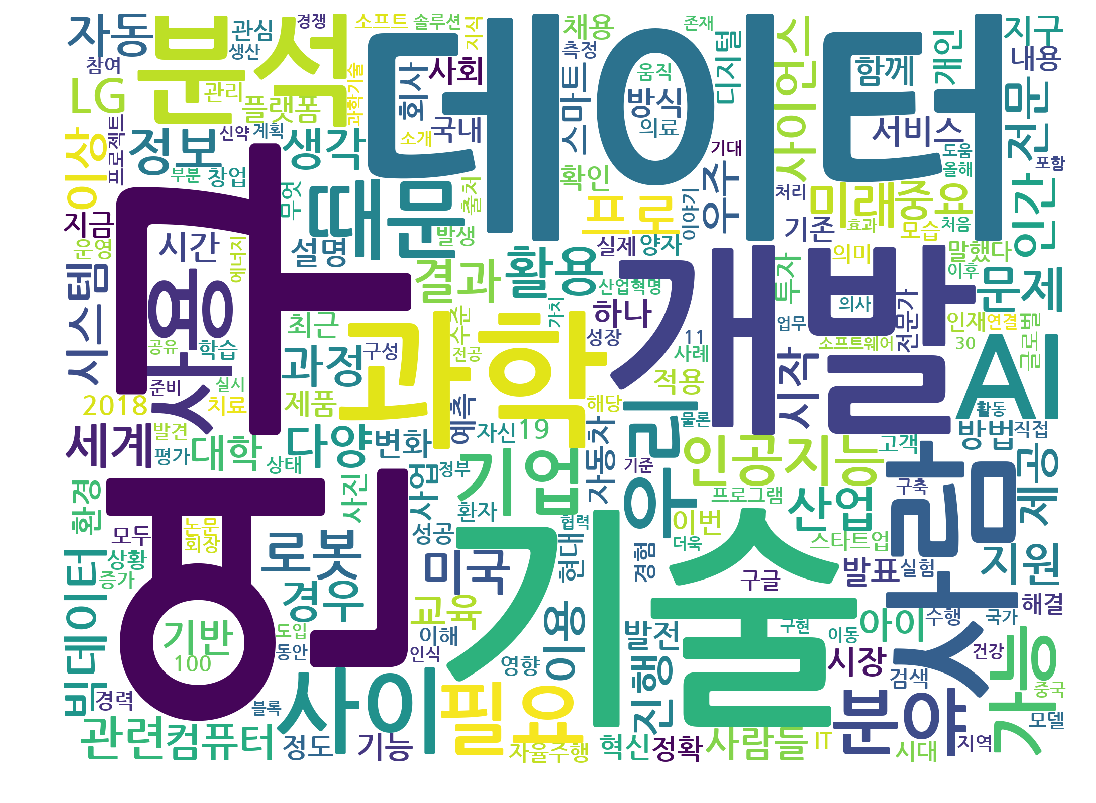

In [12]:
%%time
draw_wordcloud(words)

- soynlp로 text tokenizing
- cohesion score와 branching entropy를 통해 단어 점수 산출
- 비지도 학습 기반 tokenizer 이기 때문에 신조어 검출 등에 강한 모습을 보임. 
- 이후 분석은 konlpy의 kkma, Okt로 진행하였음

#### konlpy의  Okt로 Tokenizing 후 WordCloud 작성
1. kkma는 단어를 세세하게 나누는 패키지이다. 
2. 이보다는 Okt로 명사 위주의 tokenizing을 하는 것이 더 적합할 것으로 판단하였음.

In [51]:
%%time
words = extract_nouns('Okt', line)


15194개의 명사를 추출하였습니다.
Wall time: 3min 13s


In [52]:
len(words)

15194

- 각각의 post내 문장들이 15194개의 단어로 쪼개졌음.
- tqdm 패키지를 통해 진행률을 bar 형태로 표시

Wall time: 10.2 s


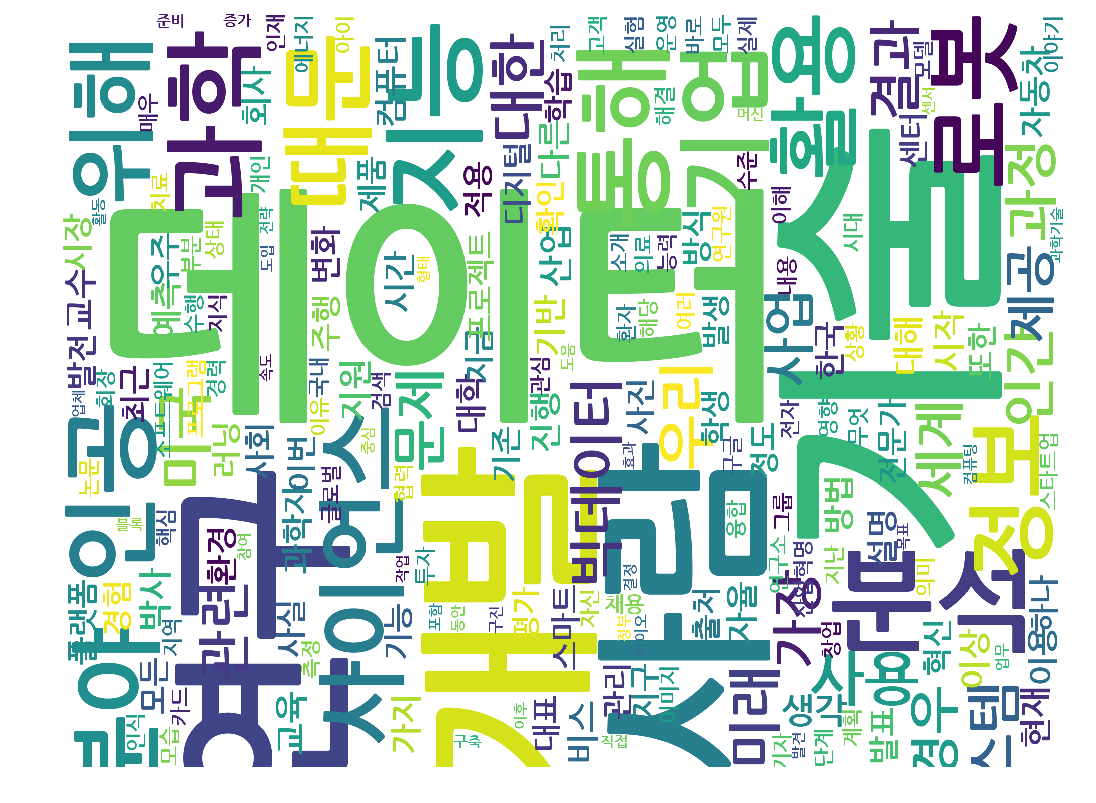

In [53]:
%%time
#wordcloud 그리기
draw_wordcloud(words)

- 데이터, 기술, 연구, 개발, 사람, 기업, 활용, 적용, 분석 등의 단어가 눈에 띔
- 새롭게 쏟아져 나오는 기술, 연구과정, 그리고 그것을 해낼 수 있는 사람에 대한 니즈가 있는 것은 아닐지
- 기술 자체에 천착하기 보다 어떻게 활용할 것인지에 대한 니즈 존재
- soynlp 패키지를 통해 만든 wordcloud와 구성이 조금 다름

#### konlpy의  kkma로 Tokenizing 후 WordCloud 작성할 경우

In [136]:
%%time
words_ = extract_nouns('Kkma', line)


32622개의 명사를 추출하였습니다.
Wall time: 11min 44s


In [137]:
len(words_)

32622

Wall time: 11.6 s


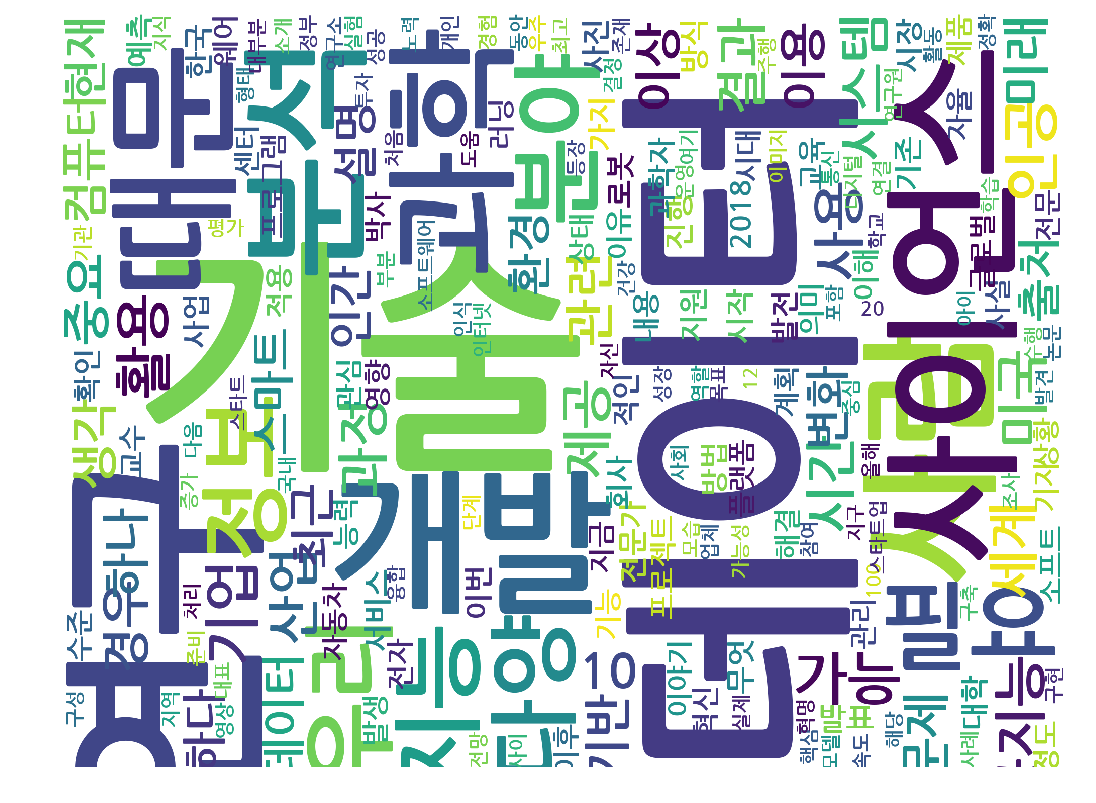

In [138]:
%%time
draw_wordcloud(words_)

#### 형태소 단위로 분리

In [65]:
%%time
line_for_word2vec = [Okt().morphs(l) for l in tqdm(line)]

Wall time: 3min 15s


#### Word2Vec으로 학습
1. gensim 패키지 내의 word2vec 알고리즘을 사용하였음.
2. 단어의 의미를 300차원으로 embedding, 한 단어의 양 옆 5개씩의 단어를 보게 하여 문맥을 파악했고, 1000회 반복하였음. skip-gram 모델 활용

In [66]:
%%time
#word embedding model
embedding_model = Word2Vec(line_for_word2vec, size=300, window = 5, 
                           min_count=10, workers=4, iter=10, sg=1)

Wall time: 16.9 s


- word2vec 알고리즘에는 cbow와 skip-gram 방식이 내장되어 있는데, 문장의 수가 그렇게 많지는 않지만, 노트북의 성능상 skip-gram을 활용하는 것이 적절하다고 판단하였음.

In [67]:
embedding_model.save('word2vec_model.bin')

In [68]:
embedding_model = Word2Vec.load('word2vec_model.bin')

In [72]:
for top in embedding_model.most_similar(positive=['데이터'], topn=10):
    print(top)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



('방대한', 0.6427055597305298)
('데이터베이스', 0.5798102617263794)
('수집', 0.5421885251998901)
('정제', 0.5415793657302856)
('처리', 0.5358572602272034)
('도구', 0.5341230034828186)
('비정', 0.5276124477386475)
('트는', 0.5274933576583862)
('빅데이터', 0.519477128982544)
('화해', 0.5151017904281616)


- '데이터'라는 단어와 유사하다고 판단된 상위 10개 단어 출력
- 그럴듯한 단어들이 추출되었다.

#### Fast Text 모델로 학습
1. fast text 모델은 facebook에서 개발한 알고리즘으로 sub-word를 추출해 낼 수 있는 장점이 있음.
2. 예를 들어 word2vec은 "데이터사이언스"라는 단어를 하나의 단어로 인식하지만, fast text는 "데이터사이언스"안에 "데이터", "사이언스"라는 단어가 들어있다고 판단함.
3. 따라서 실제로 corpus에 포함되어 있지 않은 단어라 하더라도, sub-word라면 유사도를 판단해볼 수 있음.
4. 본 과제 처럼 text의 양이 적은 경우에 사용할 경우 적절할 것이라고 판단하였음.

In [75]:
%%time
embedding_model_fasttext = FastText(line_for_word2vec, size=300, window = 5,
                                   min_count=10, workers=4, iter=10, sg=1)

Wall time: 21.2 s


In [76]:
embedding_model_fasttext.save('fasttext_model.bin')

In [77]:
embedding_model_fasttext = Word2Vec.load('fasttext_model.bin')

In [79]:
embedding_model_fasttext.most_similar(positive=['머신러닝'], topn=10)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('머신', 0.9768221378326416),
 ('러닝', 0.9766859412193298),
 ('딥', 0.8075710535049438),
 ('기계학습', 0.7346203923225403),
 ('Learning', 0.7183005213737488),
 ('자연어', 0.7171963453292847),
 ('라이브러리', 0.7039194107055664),
 ('Deep', 0.6992876529693604),
 ('신경망', 0.6599581241607666),
 ('알고리즘', 0.6578227281570435)]

- '머신러닝'이라는 단어는 원래의 corpus에 속해 있지 않으나, 속한 단어라고 판단하였음.
- 의미도 그럴듯하게 검출된 것으로 보임
- '머신러닝'이라는 단어가 corpus에 포함되지 않은 이유는, Okt 패키지의 vocabulary에 '머신러닝'이라는 단어가 들어가있지 않기 때문. soynlp로 tokenizing할 경우 비지도학습/통계 기반으로 작동하기 때문에 '머신러닝'이라는 단어를 검출해나, 본 과제는 text의 양이 적어서 성능이 저하되었음.

#### Word vectors plotting in 3D-coord
1. 300차원으로 표현된 word vector를 pca 기법을 활용하여 3차원으로 축소
2. 축소된 word vector들을 plotly 패키지를 활용해 interactive visualization

In [80]:
%%time
tsne_words_plot(embedding_model_fasttext)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



Wall time: 7min 39s


## 2. 채용사이트 데이터분석을 통한 기업별 "데이터" 관련 Job Opening Requirement 분석
1. 크롤링 대상: 잡플래닛, 원티드, 링크드인에 공고된 79개 회사
2. 분석항목
> 최종학력 조건 <br>
> 실무경험 및 분석스킬 / 툴 조건<br>
> 채용 직종 별 분석스킬 요구 조건<br>
> 채용 직종 및 분석스킬 간 상관관계 분석<br>



In [81]:
df_jd = pd.read_excel('jdlist.xlsx')

- 사이트 마다, 회사 마다 조건들이 너무 각양각색으로 표현되어 있었음
>Python, python, 파이썬, 파이선이 같은 단어<br>
>데이터 분석가, 데이터 전문가, 데이터 스페셜리스트, 데이터 애널리스트가 같은 직종<br>
>데이터 사이언티스트 채용이 실제로는 컨설턴트 채용인 경우<br>
>데이터 분석가가 실은 비즈니스 애널리스트 with excel 인 경우 등<br>

- 그래서 눈으로 보고 손으로 갈랐습니다.

In [82]:
df_jd.loc[df_jd['Keras'].isnull(), 'Keras'] = 0

In [83]:
df_jd.shape[0]

79

- 79개 회사 정보 수집 완료

#### 최종학력 별 요구 스킬 분포
개인적으로 최종학력이 data-thing job을 구하는데 많은 영향을 미친다고 생각하고 있었기 때문에 수집한 채용공고에서도 그러한 패턴이 발견되는지 확인

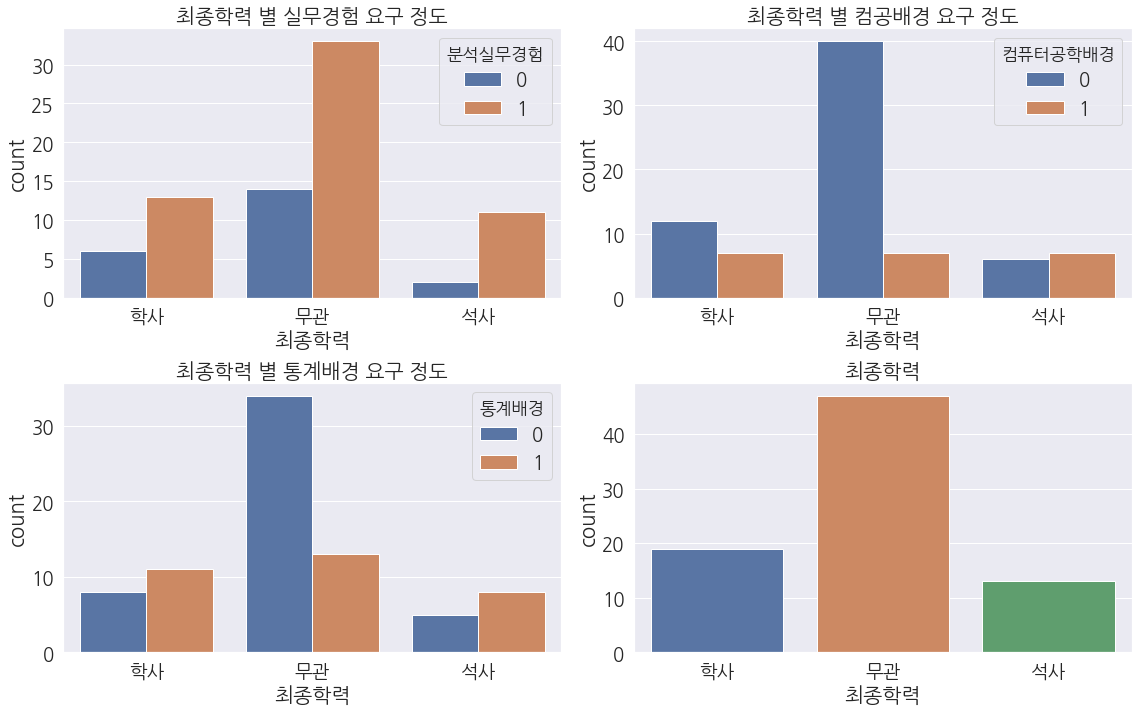

In [84]:
f, ax = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(x='최종학력', hue='분석실무경험', data=df_jd, ax=ax[0, 0])
ax[0, 0].set_title('최종학력 별 실무경험 요구 정도')
sns.countplot(x='최종학력', hue='컴퓨터공학배경', data=df_jd, ax=ax[0, 1])
ax[0, 1].set_title('최종학력 별 컴공배경 요구 정도')
sns.countplot(x='최종학력', hue='통계배경', data=df_jd, ax=ax[1, 0])
ax[1, 0].set_title('최종학력 별 통계배경 요구 정도')
sns.countplot(x='최종학력', data=df_jd, ax=ax[1, 1])
ax[1, 1].set_title('최종학력')
plt.tight_layout()
plt.show()

사실은
>실무경험이 가장 중요함<br>
최종학력을 보지 않는 회사인 경우 __실무경험__을 중시함<br>
석사 이상을 원하는 회사인 경우 __컴퓨터공학전공__, __통계전공배경__을 체크함<br>

In [85]:
df_jd.columns

Index(['기업명', '최종학력', '직종', '분석실무경험', '컴퓨터공학배경', '통계배경', '경진대회_논문', '머신러닝',
       '딥러닝', '검색엔진', '데이터베이스', 'NLP', 'Python', 'R', 'C++', 'Caffe',
       'Tensorflow', 'Theano', 'Keras', 'Pytorch', '시각화툴', 'MsOffice',
       '대용량아키텍쳐'],
      dtype='object')

#### 요구 스킬 및 툴의 분포

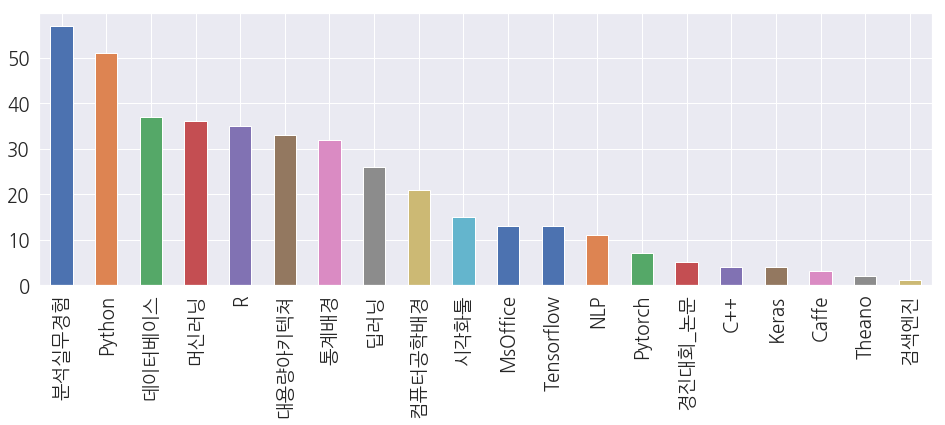

In [86]:
plt.figure(figsize=(16, 5))
df_jd[df_jd.columns[3:]].sum().sort_values(ascending=False).plot(kind='bar')

- 실무경험이 있는 Python 숙련자, SQL로 데이터에 스스로 접근 가능해야 하며 머신러닝에 대한 이해가 있는 사람. 그리고 그것을 대용량 아키텍쳐에서 실제 서비스로 만들어 내야 하는 사람
- 사람이라기 보다는 팀의 역량에 가까워 보이는데...

#### 채용 직종 분포

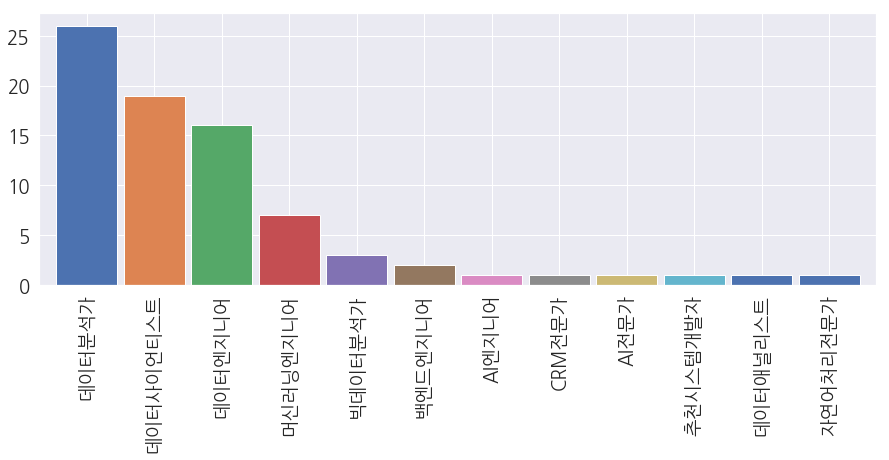

In [87]:
plt.figure(figsize=(15, 5))
df_jd['직종'].value_counts().plot.bar(width=.9)

- 데이터분석가, 데이터사이언티스트, 데이터엔지니어 위주의 채용이 이루어지고 있음.

#### 채용 직종 별 요구 스킬 수준 시각화

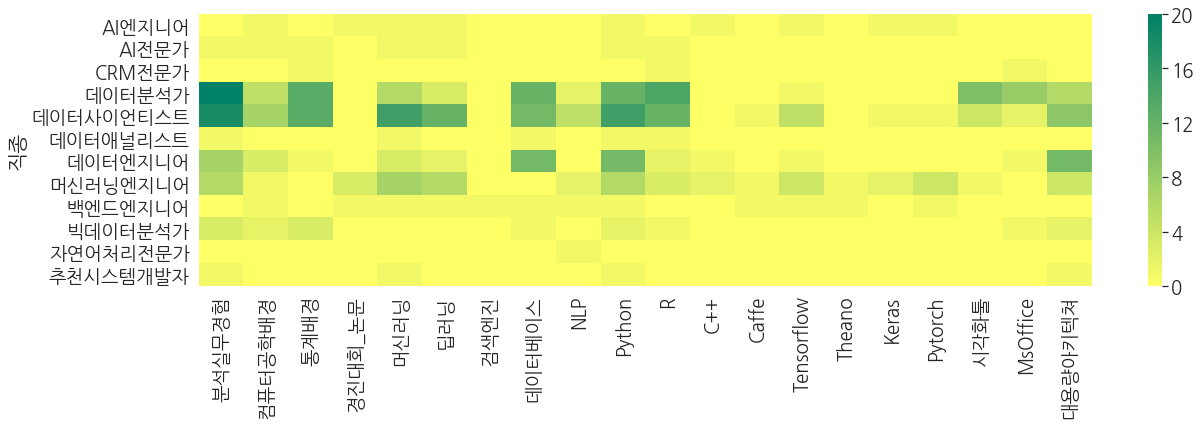

In [88]:
plt.figure(figsize=(20, 5))
sns.heatmap(df_jd[df_jd.columns[2:]].groupby(['직종']).sum(), cmap='summer_r')
plt.show()

- __데이터분석가__와 __데이터사이언티스트__가 가장 많은 역량을 갖춰야 한다.
- 그 다음은 데이터엔지니어 > 머신러닝엔지니어 순서

#### feature들 간의 상관관계 파악

In [89]:
df_jd = pd.get_dummies(df_jd, columns=['최종학력', '직종'])

- categorical value에 대해 one-hot encoding 수행

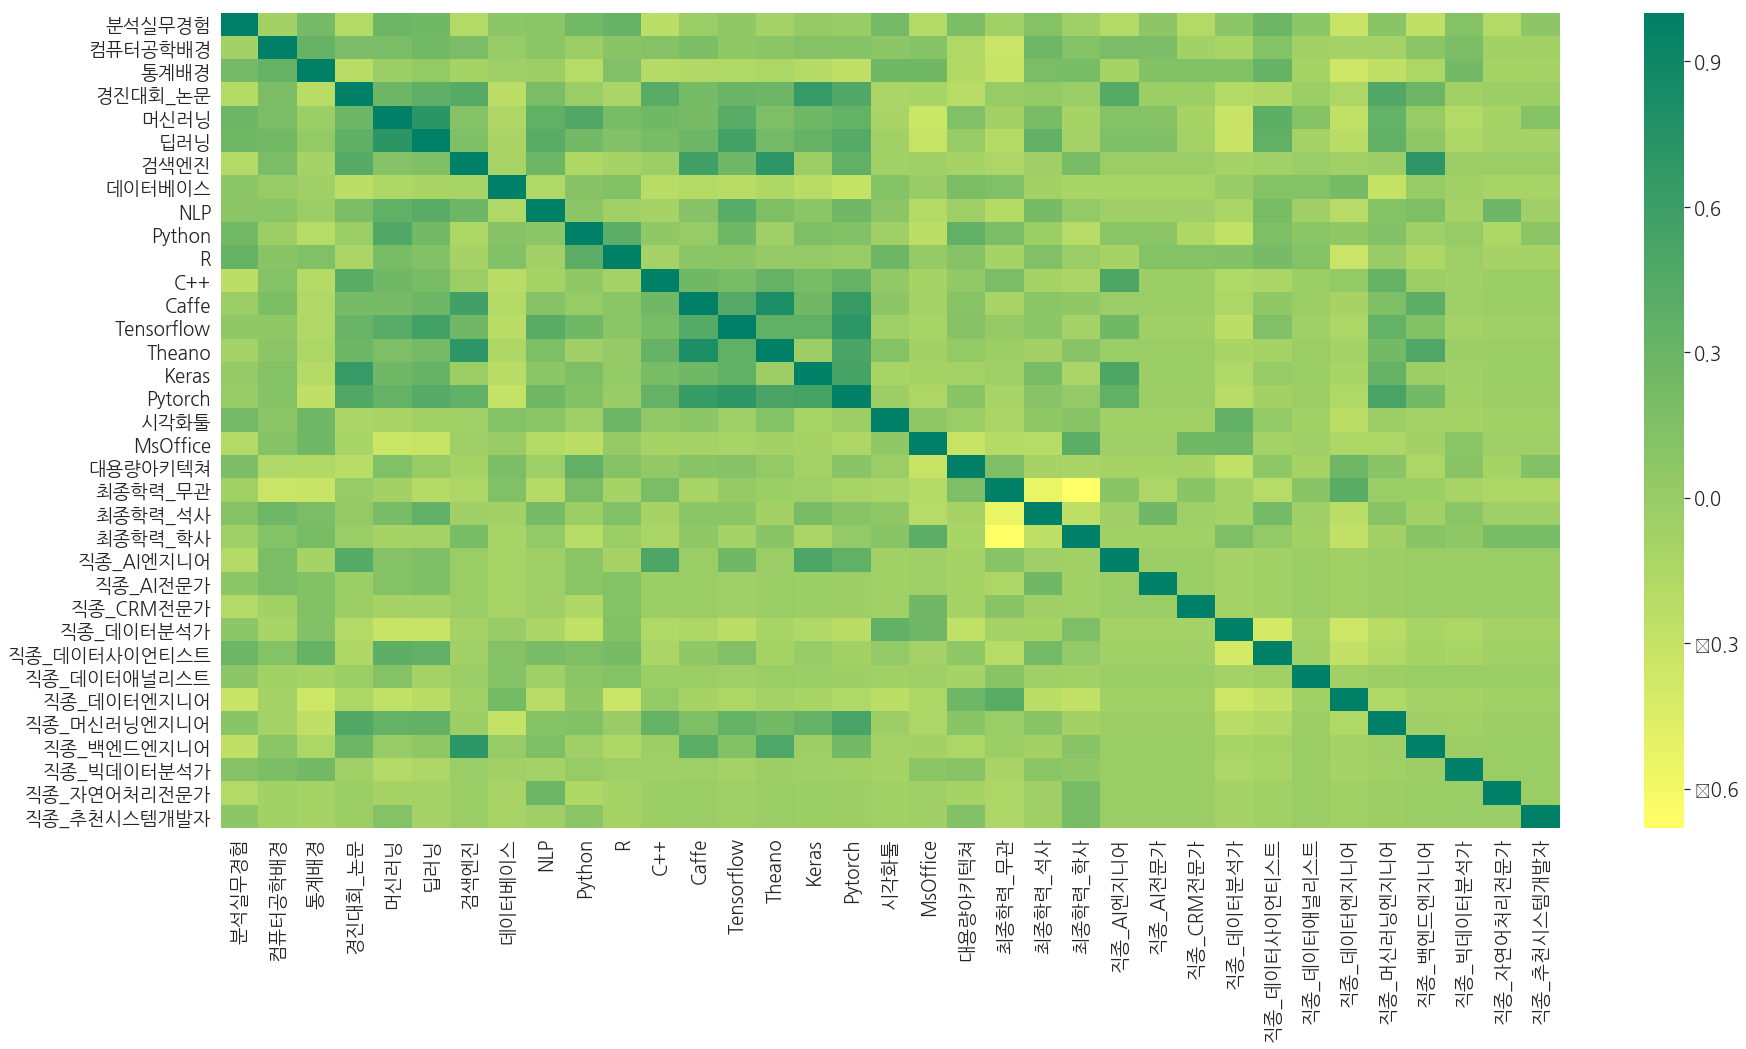

In [90]:
plt.figure(figsize=(30, 15))
sns.heatmap(df_jd.corr(), cmap='summer_r')

- 잘 안보이니까, 상관계수 0.33이상은 1로, 0.33 이하는 0으로 매핑하여 다시 히트맵
- 0.33은 약한 상관관계가 있다고 생각하는 thredshold

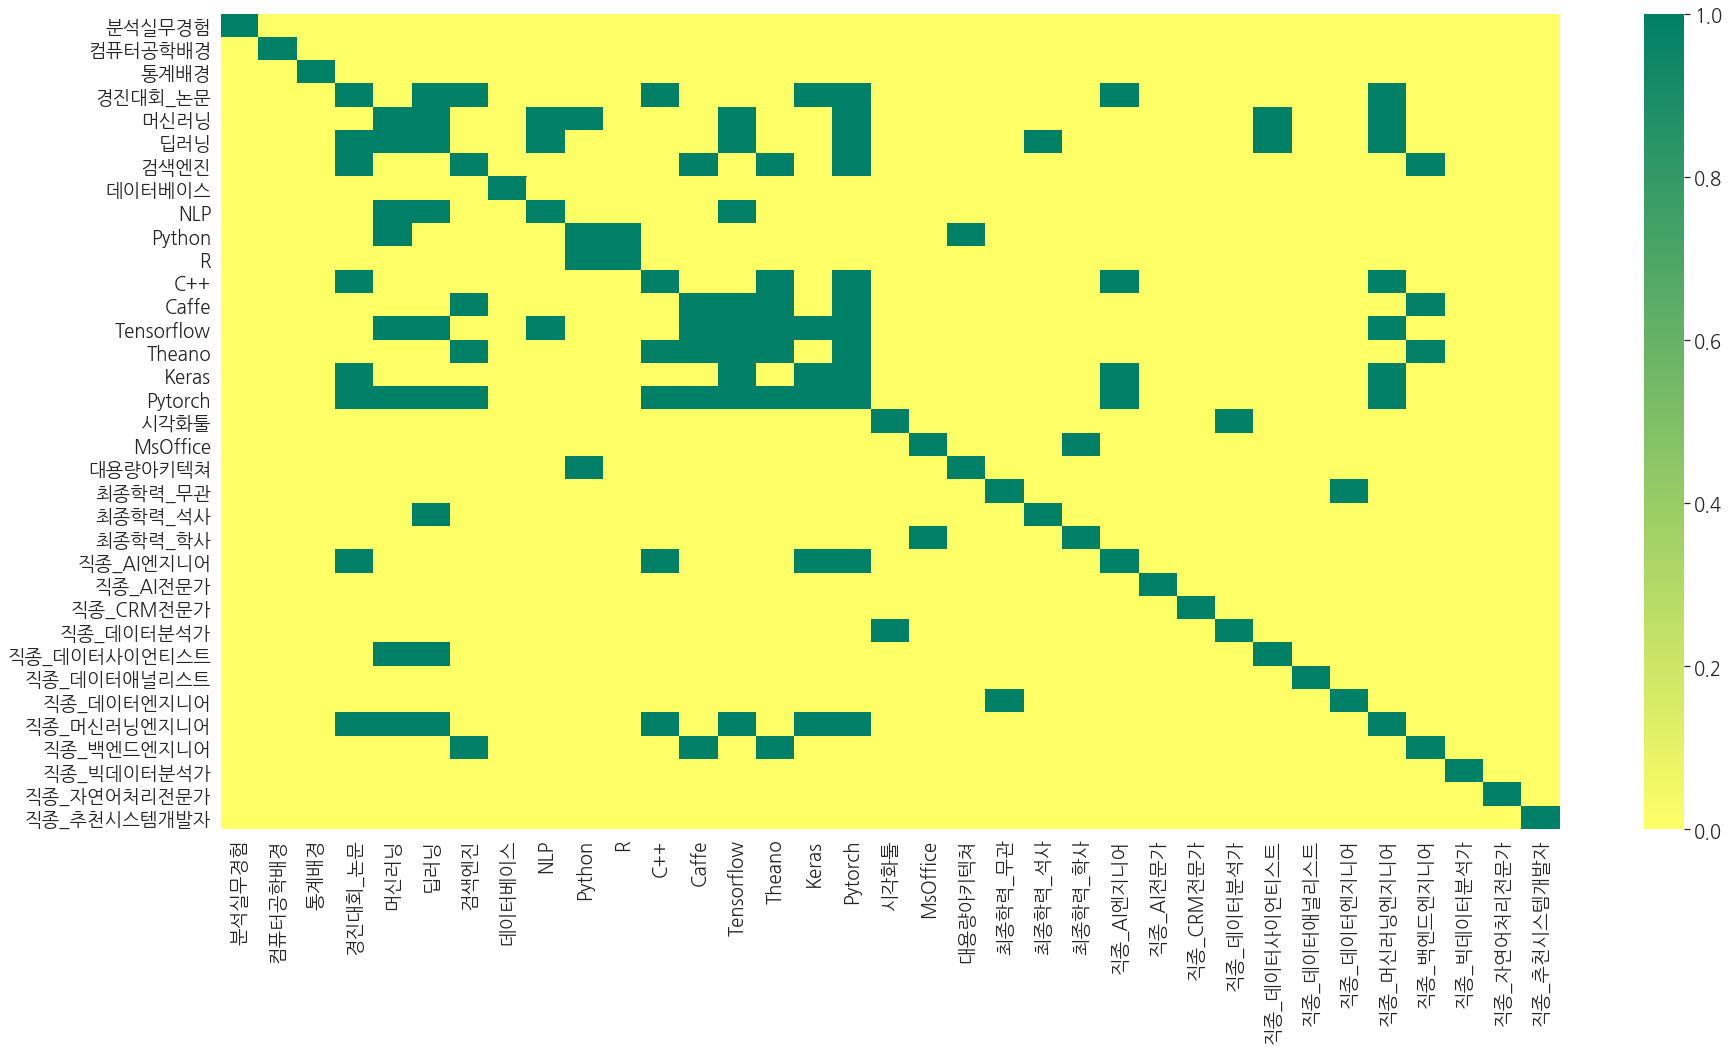

In [91]:
plt.figure(figsize=(30, 15))
sns.heatmap(df_jd.corr().applymap(lambda x: 1 if x > 0.33 else 0), cmap='summer_r')

- 어느 정도 유의미한 관계가 보이는 것 같기도 함.
- 경진대회/논문이 가장 많은 feature들과의 상관관계가 나타남
- 머신러닝 엔지니어가 그 다음으로 보임
- 하지만 상관관계 자체가 크지 않은 feature들이기 때문에, Clustering과 Classification에 모든 feature들을 사용하는 것으로 결정함

### 3. 채용기업 클러스터링 분석 - 계층적 클러스터링 활용
- 계층적 클러스터링은 cluster 숫자를 지정하지 않고도 클러스터링 가능
- 각 기업에 대해 label이 주어지지 않았기 때문에 제대로 클러스터링이 되었는지도 알 수 없음
- 또한 후에 각 기업별로 부여된 cluster number를 label로 간주하고 Classification을 수행할 것임.
- 이러한 문제들로, 계층적 클러스터링을 통해 cluster의 숫자를 지정하지 않고 적정 수준에서 클러스터링을 종료하는 것으로 결정

In [117]:
labels = df_jd['기업명']
df_jd = df_jd.drop(['기업명'], axis=1)

#### 계층적 클러스터링을 dendrogram을 통해 시각화

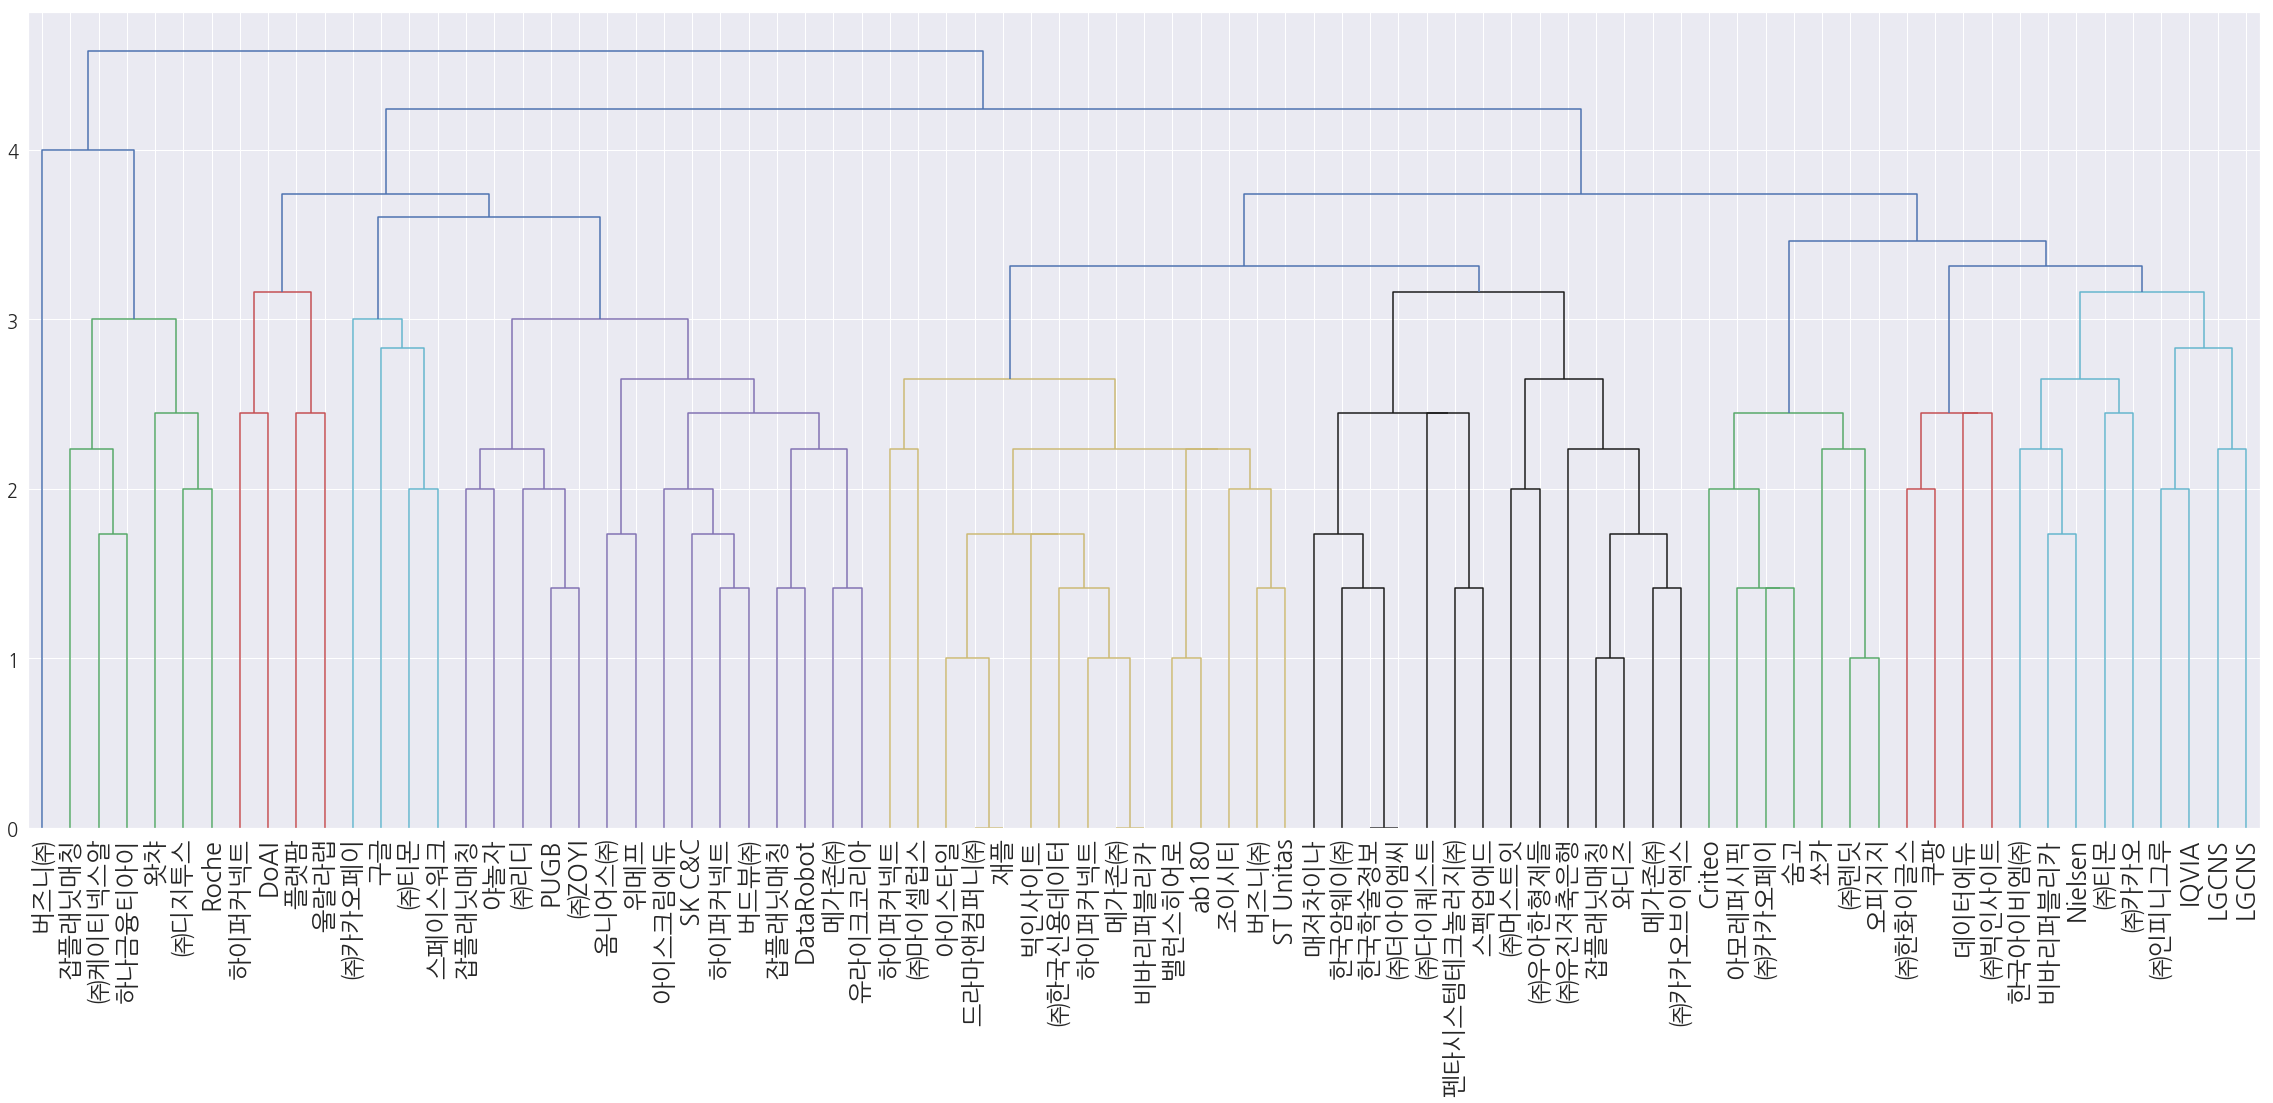

In [118]:
# Calculate the linkage
mergings = linkage(df_jd, method='complete')

# Plot the dendrogram
plt.figure(figsize=(40,15))
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=25,
           labels=labels.values
)
plt.show()

- 대략적으로 관찰할수는 있으나 자세히 보기는 어려우니, 조금 더 손대보겠습니다.

#### cluster가 3단계에서 묶이면 clustering 종료

In [119]:
predict = pd.DataFrame(fcluster(mergings, 3, criterion='distance'))
predict.columns=['predict']
labels = pd.DataFrame(labels)
labels.columns = ['firm']
result = pd.concat([labels, predict], axis=1)

In [120]:
result.predict.value_counts()

7     15
6     15
10     7
9      7
8      7
1      6
12     5
13     4
11     4
5      4
4      2
3      2
2      1
Name: predict, dtype: int64

- 13개의 클러스터로 그룹핑이 되었음.

In [121]:
result.groupby(['predict']).get_group(7)

,firm,predict
1,하이퍼커넥트,7
4,하이퍼커넥트,7
7,버즈니㈜,7
14,메가존㈜,7
16,비바리퍼블리카,7
26,드라마앤컴퍼니㈜,7
28,㈜마이셀럽스,7
30,㈜한국신용데이터,7
58,밸런스히어로,7
59,아이스타일,7


- 7번 클러스터에 속한 회사들의 목록

#### Clustered firms plotting in 3D-coord

In [122]:
tsne_clustering_plot(df_jd, labels, predict)

### 4. 채용기업 Random Forest Classification
1. 지원자가 어떤 회사에 가까운지 알아보기 위해 Random Forest를 통해 학습하고자 함.
2. label이 주어지지 않았기 때문에, 위 단계에서 나온 cluster number를 label로 간주하고 학습

#### Random Forest Classifier 학습

In [123]:
rf = RandomForestClassifier(n_estimators=300)

In [124]:
rf.fit(df_jd, predict)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### 학습 후 Classifier의 feature importance 확인

In [125]:
importances = pd.DataFrame({'feature':df_jd.columns, 'importance':rf.feature_importances_})

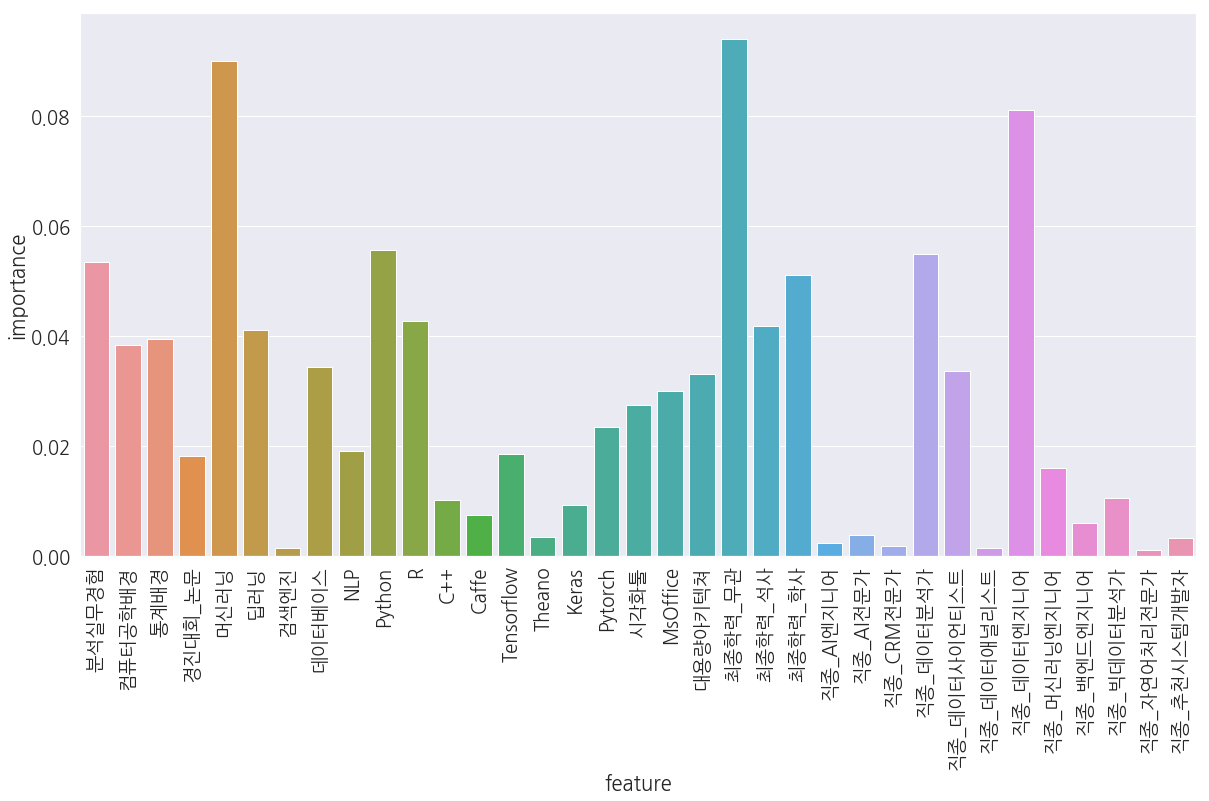

In [126]:
plt.figure(figsize=(20, 10))
g = sns.barplot(x='feature', y='importance', data=importances)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

- 회사별로 분류를 할 때, 머신러닝 경험 여부, 학력은 무관, 데이터엔지니어 채용 여부, 파이선 경험 여부, 분석실무경험 여부가 강한 영향을 미침.
- 요건 Count 기반으로 직종을 분류하였을 때, 가장 많이 고려되던 요인과도 일치함
- 다만 회사를 분류하는데 얼마나 고려되는지를 알 수 있을 뿐, 필드에서 각 요건들이 갖는 중요도를 표현한 것으로 생각할 수는 없음.

### 5. 네이버 포스트 아티클과 채용사이트 Requirement 비교
1. Clustering and Classification에서 알아본 주요 요건에 해당하는 단어 들이 네이버 포스트 아티클에서 어떤 의미를 가지는지 알아보고자 함
2. Fast text 알고리즘으로 학습된 단어 벡터들을 통해 각 요건들과 유사하다고 판단되는 아티클 상의 단어들을 살펴본다.
3. 이것이 실제로 어떤 의미를 갖는지를 알아보기 위해서는 문장 분류기를 만들어 보는 것이 좋으며, 더 많은 수의 text가 필요할 것이다.

In [104]:
embedding_model_fasttext.most_similar(positive=['머신러닝'], topn=30)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('머신', 0.9768221378326416),
 ('러닝', 0.9766859412193298),
 ('딥', 0.8075710535049438),
 ('기계학습', 0.7346203923225403),
 ('Learning', 0.7183005213737488),
 ('자연어', 0.7171963453292847),
 ('라이브러리', 0.7039194107055664),
 ('Deep', 0.6992876529693604),
 ('신경망', 0.6599581241607666),
 ('알고리즘', 0.6578227281570435),
 ('기법', 0.6360325813293457),
 ('CNN', 0.623002290725708),
 ('추론', 0.622528612613678),
 ('음성인식', 0.6120114326477051),
 ('비전', 0.6077291369438171),
 ('오믹스', 0.6028200387954712),
 ('심층', 0.6015691757202148),
 ('튜링', 0.5800406336784363),
 ('텐서', 0.5778000950813293),
 ('시뮬레이션', 0.5765998959541321),
 ('도구', 0.570171058177948),
 ('오픈소스', 0.5626819133758545),
 ('Analytics', 0.5616230368614197),
 ('신비', 0.5613781213760376),
 ('허사비스', 0.5592430233955383),
 ('고성능', 0.5582464933395386),
 ('신경과학', 0.5579769015312195),
 ('그래픽', 0.5561147928237915),
 ('GPU', 0.5540424585342407),
 ('모형', 0.5476903915405273)]

In [105]:
embedding_model_fasttext.most_similar(positive=['학위'], topn=30)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('박사학위', 0.894280195236206),
 ('석사', 0.8461020588874817),
 ('학사', 0.7764090299606323),
 ('취득', 0.7604410648345947),
 ('경영학', 0.7364444732666016),
 ('졸업', 0.7279677987098694),
 ('종사', 0.7069311141967773),
 ('소지', 0.697222113609314),
 ('이수', 0.6940446496009827),
 ('컴퓨터공학', 0.6909076571464539),
 ('회계사', 0.6865607500076294),
 ('4년', 0.6841657161712646),
 ('자로', 0.6839410662651062),
 ('진학', 0.6785147190093994),
 ('대학원', 0.670329213142395),
 ('언어학', 0.6694227457046509),
 ('전공자', 0.6655656695365906),
 ('대학생', 0.6651411056518555),
 ('이상인', 0.6611588001251221),
 ('변호사', 0.6568964123725891),
 ('재직', 0.6550121307373047),
 ('대학원생', 0.6500781178474426),
 ('대리', 0.6482582092285156),
 ('메이슨', 0.6476600766181946),
 ('튼', 0.6442551612854004),
 ('입학', 0.6439852118492126),
 ('신입', 0.6414143443107605),
 ('변리사', 0.6390674114227295),
 ('공무원', 0.6362292766571045),
 ('7년', 0.6344246864318848)]

In [106]:
embedding_model_fasttext.most_similar(positive=['학사'], topn=30)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('석사', 0.8020421266555786),
 ('이수', 0.7845675945281982),
 ('학위', 0.7764090299606323),
 ('박사학위', 0.7650840878486633),
 ('컴퓨터공학', 0.708854079246521),
 ('영어', 0.6949304342269897),
 ('개설', 0.6833692789077759),
 ('경영학', 0.6812998056411743),
 ('언어학', 0.6732494831085205),
 ('졸업', 0.6623878479003906),
 ('취득', 0.6527698040008545),
 ('4년', 0.6511205434799194),
 ('한양대', 0.6452080011367798),
 ('종사', 0.6421448588371277),
 ('진학', 0.6419072151184082),
 ('사회과학', 0.6379019021987915),
 ('모집', 0.6368974447250366),
 ('요건', 0.6356485486030579),
 ('하시면', 0.6352399587631226),
 ('학과', 0.6336402893066406),
 ('심화', 0.6326531171798706),
 ('회계사', 0.6310597658157349),
 ('전공자', 0.6303921937942505),
 ('수강', 0.6295361518859863),
 ('교과', 0.629095196723938),
 ('고등학교', 0.6285181045532227),
 ('대학생', 0.6278798580169678),
 ('UX', 0.6264522075653076),
 ('전문직', 0.6255872249603271),
 ('인문', 0.62513267993927)]

In [107]:
embedding_model_fasttext.most_similar(positive=['석사'], topn=30)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('박사학위', 0.8694506287574768),
 ('학위', 0.8461020588874817),
 ('경영학', 0.8040071725845337),
 ('학사', 0.8020421266555786),
 ('취득', 0.7914516925811768),
 ('이수', 0.787717342376709),
 ('컴퓨터공학', 0.7800676226615906),
 ('개설', 0.7684574127197266),
 ('건국대', 0.7459161281585693),
 ('요건', 0.7452083230018616),
 ('회계사', 0.7441139221191406),
 ('대학생', 0.739070475101471),
 ('회계', 0.737534761428833),
 ('대학원', 0.7311954498291016),
 ('공무원', 0.7284589409828186),
 ('변리사', 0.7275739908218384),
 ('졸업', 0.7251386046409607),
 ('대리', 0.7218412160873413),
 ('Studio', 0.7132531404495239),
 ('진학', 0.7035619020462036),
 ('근무', 0.7027351260185242),
 ('언어학', 0.702218770980835),
 ('소지', 0.700745701789856),
 ('고등학교', 0.6985357999801636),
 ('대학원생', 0.6939703226089478),
 ('모집', 0.6923872232437134),
 ('종사', 0.6907649040222168),
 ('임원', 0.6884819269180298),
 ('전문직', 0.6882798075675964),
 ('이상인', 0.678716778755188)]

In [108]:
embedding_model_fasttext.most_similar(positive=['데이터엔지니어'], topn=30)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('엔지니어', 0.9398822784423828),
 ('엔지니어링', 0.8170703649520874),
 ('소프트웨어', 0.7306621670722961),
 ('에어비앤비', 0.7146033048629761),
 ('관리자', 0.6424731016159058),
 ('담당자', 0.6405959129333496),
 ('트는', 0.6285481452941895),
 ('애널', 0.6050653457641602),
 ('이사', 0.5974770784378052),
 ('베이스', 0.5940393209457397),
 ('로컬', 0.5921441316604614),
 ('뱅크', 0.5883426666259766),
 ('도구', 0.5859986543655396),
 ('애플리케이션', 0.5825541615486145),
 ('직', 0.5817781090736389),
 ('하드웨어', 0.5816723108291626),
 ('리스트', 0.5788931846618652),
 ('사원', 0.5782679319381714),
 ('총괄', 0.577629804611206),
 ('데이터', 0.573689341545105),
 ('UX', 0.5705424547195435),
 ('데이', 0.5679487586021423),
 ('책임자', 0.5677372813224792),
 ('데이터베이스', 0.5676474571228027),
 ('모스', 0.5665693879127502),
 ('Studio', 0.5650749206542969),
 ('석사', 0.5645983219146729),
 ('소프트', 0.5617414712905884),
 ('DT', 0.5609629154205322),
 ('회계', 0.5606116056442261)]

In [109]:
embedding_model_fasttext.most_similar(positive=['파이썬'], topn=30)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('라이브러리', 0.7891253232955933),
 ('배우는', 0.7536705732345581),
 ('스킬', 0.7406697869300842),
 ('R', 0.7398343086242676),
 ('언어', 0.7362229824066162),
 ('프로그래밍', 0.715270459651947),
 ('기초', 0.6914084553718567),
 ('SQL', 0.6840388178825378),
 ('Python', 0.676933228969574),
 ('커리큘럼', 0.6732494235038757),
 ('실습', 0.6729621887207031),
 ('여러가지', 0.6516133546829224),
 ('통계학', 0.6448874473571777),
 ('이론', 0.6433210372924805),
 ('습득', 0.6420513391494751),
 ('굳이', 0.6415544748306274),
 ('하시면', 0.6397060751914978),
 ('언어학', 0.6392946839332581),
 ('쓰기', 0.6349141597747803),
 ('수학', 0.6340827941894531),
 ('위주', 0.6327914595603943),
 ('과목', 0.632692813873291),
 ('담긴', 0.6278521418571472),
 ('텍스트', 0.6273471117019653),
 ('기법', 0.6256029009819031),
 ('노트', 0.623442530632019),
 ('이수', 0.6224620342254639),
 ('컴퓨터공학', 0.6162112951278687),
 ('UX', 0.613338053226471),
 ('모델링', 0.6120755672454834)]

In [110]:
embedding_model_fasttext.most_similar(positive=['분석실무경험'], topn=30)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('분석', 0.7487910985946655),
 ('경험', 0.7486678957939148),
 ('UX', 0.6375853419303894),
 ('02', 0.593908429145813),
 ('UI', 0.5878612995147705),
 ('오믹스', 0.574993371963501),
 ('업그레이드', 0.5661433339118958),
 ('개인화', 0.5609405636787415),
 ('오픈소스', 0.559720516204834),
 ('모형', 0.5581687688827515),
 ('아우르는', 0.5553293824195862),
 ('리스크', 0.5510393381118774),
 ('계층', 0.5495403409004211),
 ('자격증', 0.5460348725318909),
 ('제휴', 0.5449820756912231),
 ('03', 0.5409821271896362),
 ('특허', 0.5394856333732605),
 ('방법론', 0.5382164716720581),
 ('노하우', 0.5373666286468506),
 ('화해', 0.5349066257476807),
 ('얻은', 0.5300089120864868),
 ('바른', 0.5282503366470337),
 ('양질', 0.5261752605438232),
 ('마케팅', 0.524351954460144),
 ('다중', 0.5231137275695801),
 ('회계', 0.5227234959602356),
 ('올바른', 0.5223091840744019),
 ('예비', 0.5221083164215088),
 ('데이터베이스', 0.5212441682815552),
 ('신규', 0.5180252194404602)]

In [111]:
embedding_model_fasttext.most_similar(positive=['시각화'], topn=30)

C:\Users\edte1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('시각', 0.9630368947982788),
 ('탐험', 0.5850396156311035),
 ('보여', 0.5421029925346375),
 ('성의', 0.5319515466690063),
 ('통찰', 0.5193084478378296),
 ('객관', 0.5144872665405273),
 ('그려', 0.5082935690879822),
 ('복사', 0.5068328380584717),
 ('입체', 0.5011889934539795),
 ('바른', 0.5006744265556335),
 ('그린', 0.4998854696750641),
 ('이르기까지', 0.4958342909812927),
 ('올바른', 0.49546074867248535),
 ('감각', 0.49112778902053833),
 ('셋', 0.4893285036087036),
 ('어떠한', 0.48679566383361816),
 ('지식인', 0.48459580540657043),
 ('비유', 0.4827428460121155),
 ('상호', 0.4759301543235779),
 ('지배', 0.47592127323150635),
 ('쉽고', 0.47570282220840454),
 ('복잡하고', 0.47563254833221436),
 ('묘사', 0.4746432900428772),
 ('단순화', 0.4737508296966553),
 ('해하', 0.4727127254009247),
 ('폭넓은', 0.4704621136188507),
 ('바꾸는', 0.4693124294281006),
 ('후각', 0.4688479006290436),
 ('멋진', 0.4687175452709198),
 ('왜곡', 0.4671996831893921)]

### 5. 여러분은 어떤 기업의 Requirement에 가까우신가요?
내가 가진 요건, 혹은 내가 가지고 싶은 요건과 하고 싶은 직종을 넣고 어떤 회사에 가까운지 알아보자.

In [112]:
df_jd.columns

Index(['기업명', '분석실무경험', '컴퓨터공학배경', '통계배경', '경진대회_논문', '머신러닝', '딥러닝', '검색엔진',
       '데이터베이스', 'NLP', 'Python', 'R', 'C++', 'Caffe', 'Tensorflow', 'Theano',
       'Keras', 'Pytorch', '시각화툴', 'MsOffice', '대용량아키텍쳐', '최종학력_무관', '최종학력_석사',
       '최종학력_학사', '직종_AI엔지니어', '직종_AI전문가', '직종_CRM전문가', '직종_데이터분석가',
       '직종_데이터사이언티스트', '직종_데이터애널리스트', '직종_데이터엔지니어', '직종_머신러닝엔지니어',
       '직종_백엔드엔지니어', '직종_빅데이터분석가', '직종_자연어처리전문가', '직종_추천시스템개발자'],
      dtype='object')

In [127]:
my_spec = np.array([1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
                   0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [128]:
rf.predict(my_spec.reshape(1, -1))

array([6], dtype=int32)

In [129]:
result.groupby(['predict']).get_group(6)

,firm,predict
3,하이퍼커넥트,6
5,㈜리디,6
13,메가존㈜,6
18,잡플래닛매칭,6
27,잡플래닛매칭,6
32,옴니어스㈜,6
39,버드뷰㈜,6
48,SK C&C,6
51,PUGB,6
52,㈜ZOYI,6


- 이런 회사들과 가깝다고 합니다

In [130]:
your_spec = set_my_spec()

분석실무경험 원하면 1, 아니면 01
컴퓨터공학배경 원하면 1, 아니면 01
통계배경 원하면 1, 아니면 01
경진대회_논문 원하면 1, 아니면 00
머신러닝 원하면 1, 아니면 01
딥러닝 원하면 1, 아니면 01
검색엔진 원하면 1, 아니면 00
데이터베이스 원하면 1, 아니면 01
NLP 원하면 1, 아니면 00
Python 원하면 1, 아니면 01
R 원하면 1, 아니면 00
C++ 원하면 1, 아니면 00
Caffe 원하면 1, 아니면 01
Tensorflow 원하면 1, 아니면 01
Theano 원하면 1, 아니면 00
Keras 원하면 1, 아니면 01
Pytorch 원하면 1, 아니면 01
시각화툴 원하면 1, 아니면 01
MsOffice 원하면 1, 아니면 00
대용량아키텍쳐 원하면 1, 아니면 01
최종학력_무관 원하면 1, 아니면 00
최종학력_석사 원하면 1, 아니면 01
최종학력_학사 원하면 1, 아니면 00
직종_AI엔지니어 원하면 1, 아니면 00
직종_AI전문가 원하면 1, 아니면 00
직종_CRM전문가 원하면 1, 아니면 01
직종_데이터분석가 원하면 1, 아니면 01
직종_데이터사이언티스트 원하면 1, 아니면 01
직종_데이터애널리스트 원하면 1, 아니면 01
직종_데이터엔지니어 원하면 1, 아니면 00
직종_머신러닝엔지니어 원하면 1, 아니면 00
직종_백엔드엔지니어 원하면 1, 아니면 01
직종_빅데이터분석가 원하면 1, 아니면 00
직종_자연어처리전문가 원하면 1, 아니면 01
직종_추천시스템개발자 원하면 1, 아니면 00


In [134]:
rf.predict(np.array(your_spec).reshape(1, -1))

array([1], dtype=int32)

In [135]:
result.groupby(['predict']).get_group(1)

,firm,predict
33,잡플래닛매칭,1
34,㈜디지투스,1
36,㈜케이티넥스알,1
54,Roche,1
65,하나금융티아이,1
71,왓챠,1
